In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [3]:
pd.set_option('display.max_columns', None)

#####  Создаем DF

In [391]:
columns=['id',
 'region',
 'objElemLivingCnt',
 'objElemParkingCnt',
 'objSquareLiving',
 'objLkClassDesc',
 'residentialBuildings',
 'objFloorCnt',
 'objFlatCnt',
 'objFlatSq',
 'objPriceAvg',
 'objReady100PercDt']

In [506]:
df=pd.read_pickle('build.pkl')[columns].drop_duplicates('id')
df['year']=pd.to_datetime(df['objReady100PercDt']).dt.year.astype('str')
live_class = df[df['objLkClassDesc'] != 'Другое']['objLkClassDesc'].unique() 
region = df['region'].unique()

##### отбираем все классы жилья и регион, и в дальнейшем заменяем Nan цены на медиану по каждому классу объекта

In [565]:
for cla in live_class:
    for reg in region:
        filter = (df['objLkClassDesc'] == cla) & (df['region'] == reg)
        df.loc[filter,'med_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].median())
        df.loc[filter,'avg_price'] = df.loc[filter,'objPriceAvg'].fillna(df.loc[filter,'objPriceAvg'].mean())
        

df.loc[df['med_price'].isnull(),'med_price'] = df.med_price.median()
df.loc[df['avg_price'].isnull(),'avg_price'] = df.avg_price.median()

df['med_price'] = df['med_price'].astype(int)
df['avg_price'] = df['avg_price'].astype(int)


Определяем выборку регионов

<Axes: xlabel='region'>

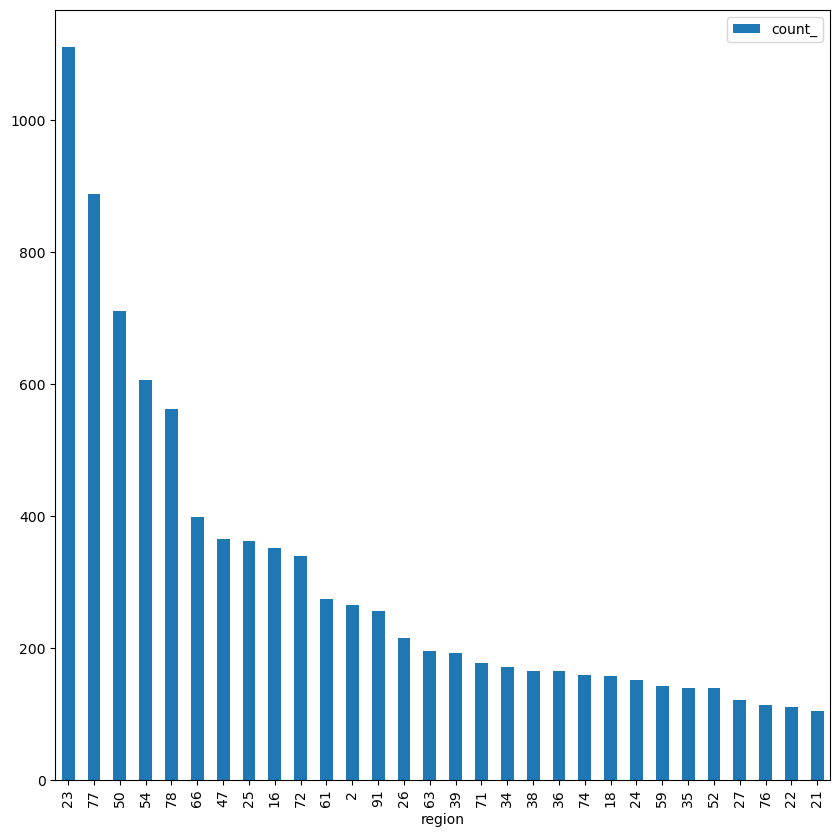

In [630]:
from pylab import rcParams
rcParams['figure.figsize'] = 9,12
df_grouped=df.groupby(['region'])['id'].count().reset_index().set_index(['region'])
df_grouped = df_grouped.rename(columns={'id': 'count_'})
df_grouped[df_grouped.count_ > 100].sort_values('count_',ascending = False).plot(kind='bar',stacked=True,figsize=(10,10))

Возьмем первые топ 5 регионов

In [620]:
top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']

In [631]:
top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']
df=df[df['region'].isin(top_reg)].reset_index(drop=True)
df.head()

,id,region,objElemLivingCnt,objElemParkingCnt,objSquareLiving,objLkClassDesc,residentialBuildings,objFloorCnt,objFlatCnt,objFlatSq,objPriceAvg,objReady100PercDt,year,med_price,avg_price
0,56006,54,24,0,1003.20,Комфорт,1,4,24,1003.2,NaN,2024-12-31,2024,116964,123119
1,18709,50,272,30,12093.84,Комфорт,1,18,272,12093.84,95270.0,2023-12-31,2023,95270,95270
2,18708,50,272,0,12057.80,Комфорт,1,17,272,12057.8,100727.0,2023-12-31,2023,100727,100727
3,27803,54,12,0,889.20,Типовой,1,3,12,889.2,NaN,2024-03-31,2024,77721,77696
4,23862,54,6,0,787.20,Типовой,1,3,6,787.2,NaN,2024-03-31,2024,77721,77696


график этажей,парковок,колв-во квартир

,region,objLkClassDesc,year,objElemLivingCnt
0,23,Бизнес,2023,205.000000
1,23,Бизнес,2024,192.363636
2,23,Бизнес,2025,245.631579
3,23,Бизнес,2026,233.571429
4,23,Бизнес,2027,891.000000
...,...,...,...,...
99,78,Элитный,2023,425.750000
100,78,Элитный,2024,118.571429
101,78,Элитный,2025,78.000000
102,78,Элитный,2026,717.000000


d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


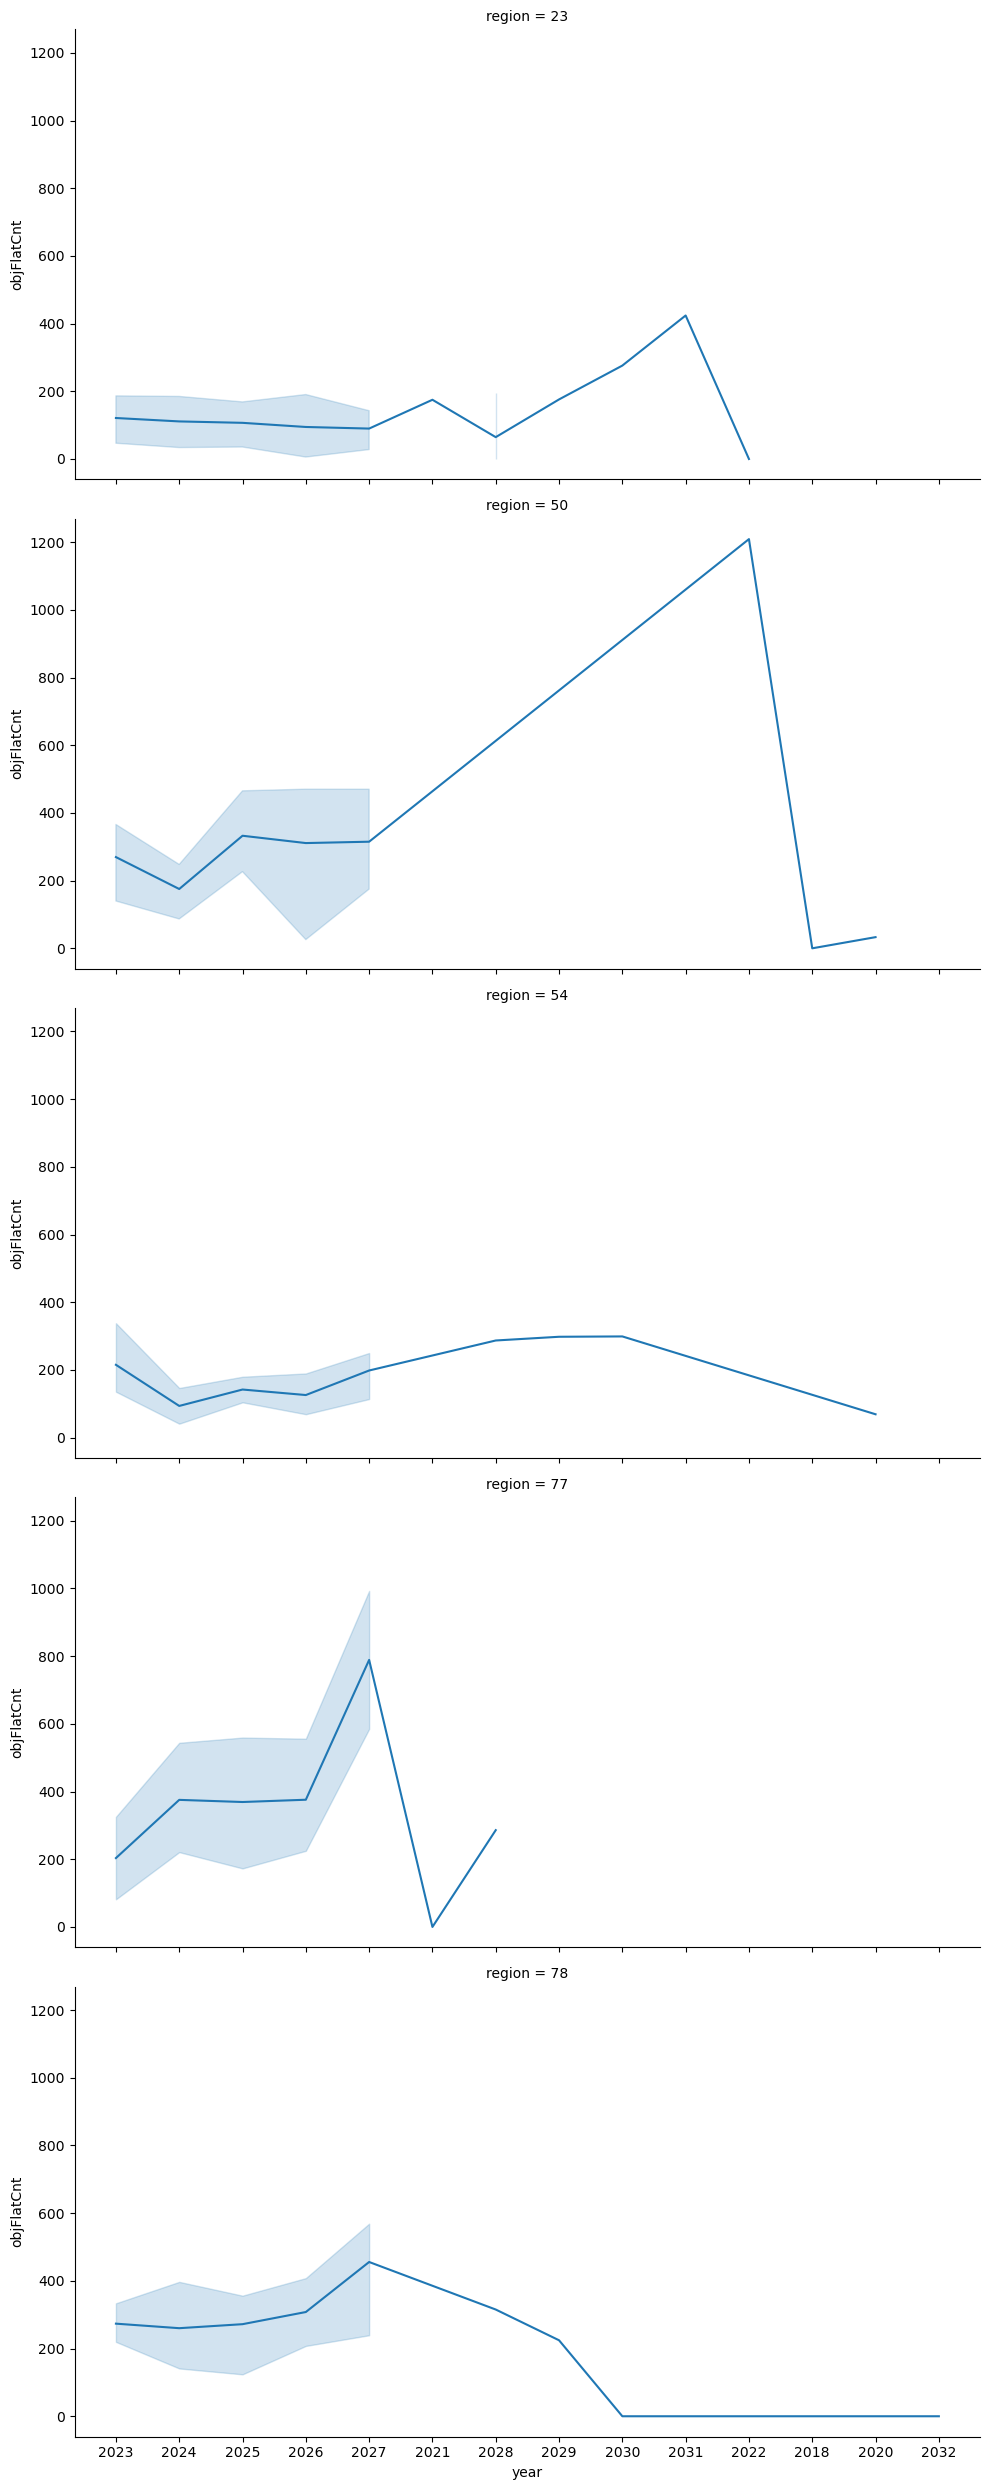

In [728]:
target=['objElemParkingCnt','objFloorCnt','objFlatCnt']
df[df.residentialBuildings == 1].groupby(['region','objLkClassDesc','year'])['objElemLivingCnt'].mean().reset_index()

sns.relplot(
    x='year',
    y='objFlatCnt',
    # hue='objLkClassDesc',
    data=df.groupby(['region','objLkClassDesc','year'])['objFlatCnt'].mean().reset_index(),
    row='region',
    kind='line',
    aspect=2,
    height=5)

В основном, ко-во этажей из года в год будет увеличиваться.

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


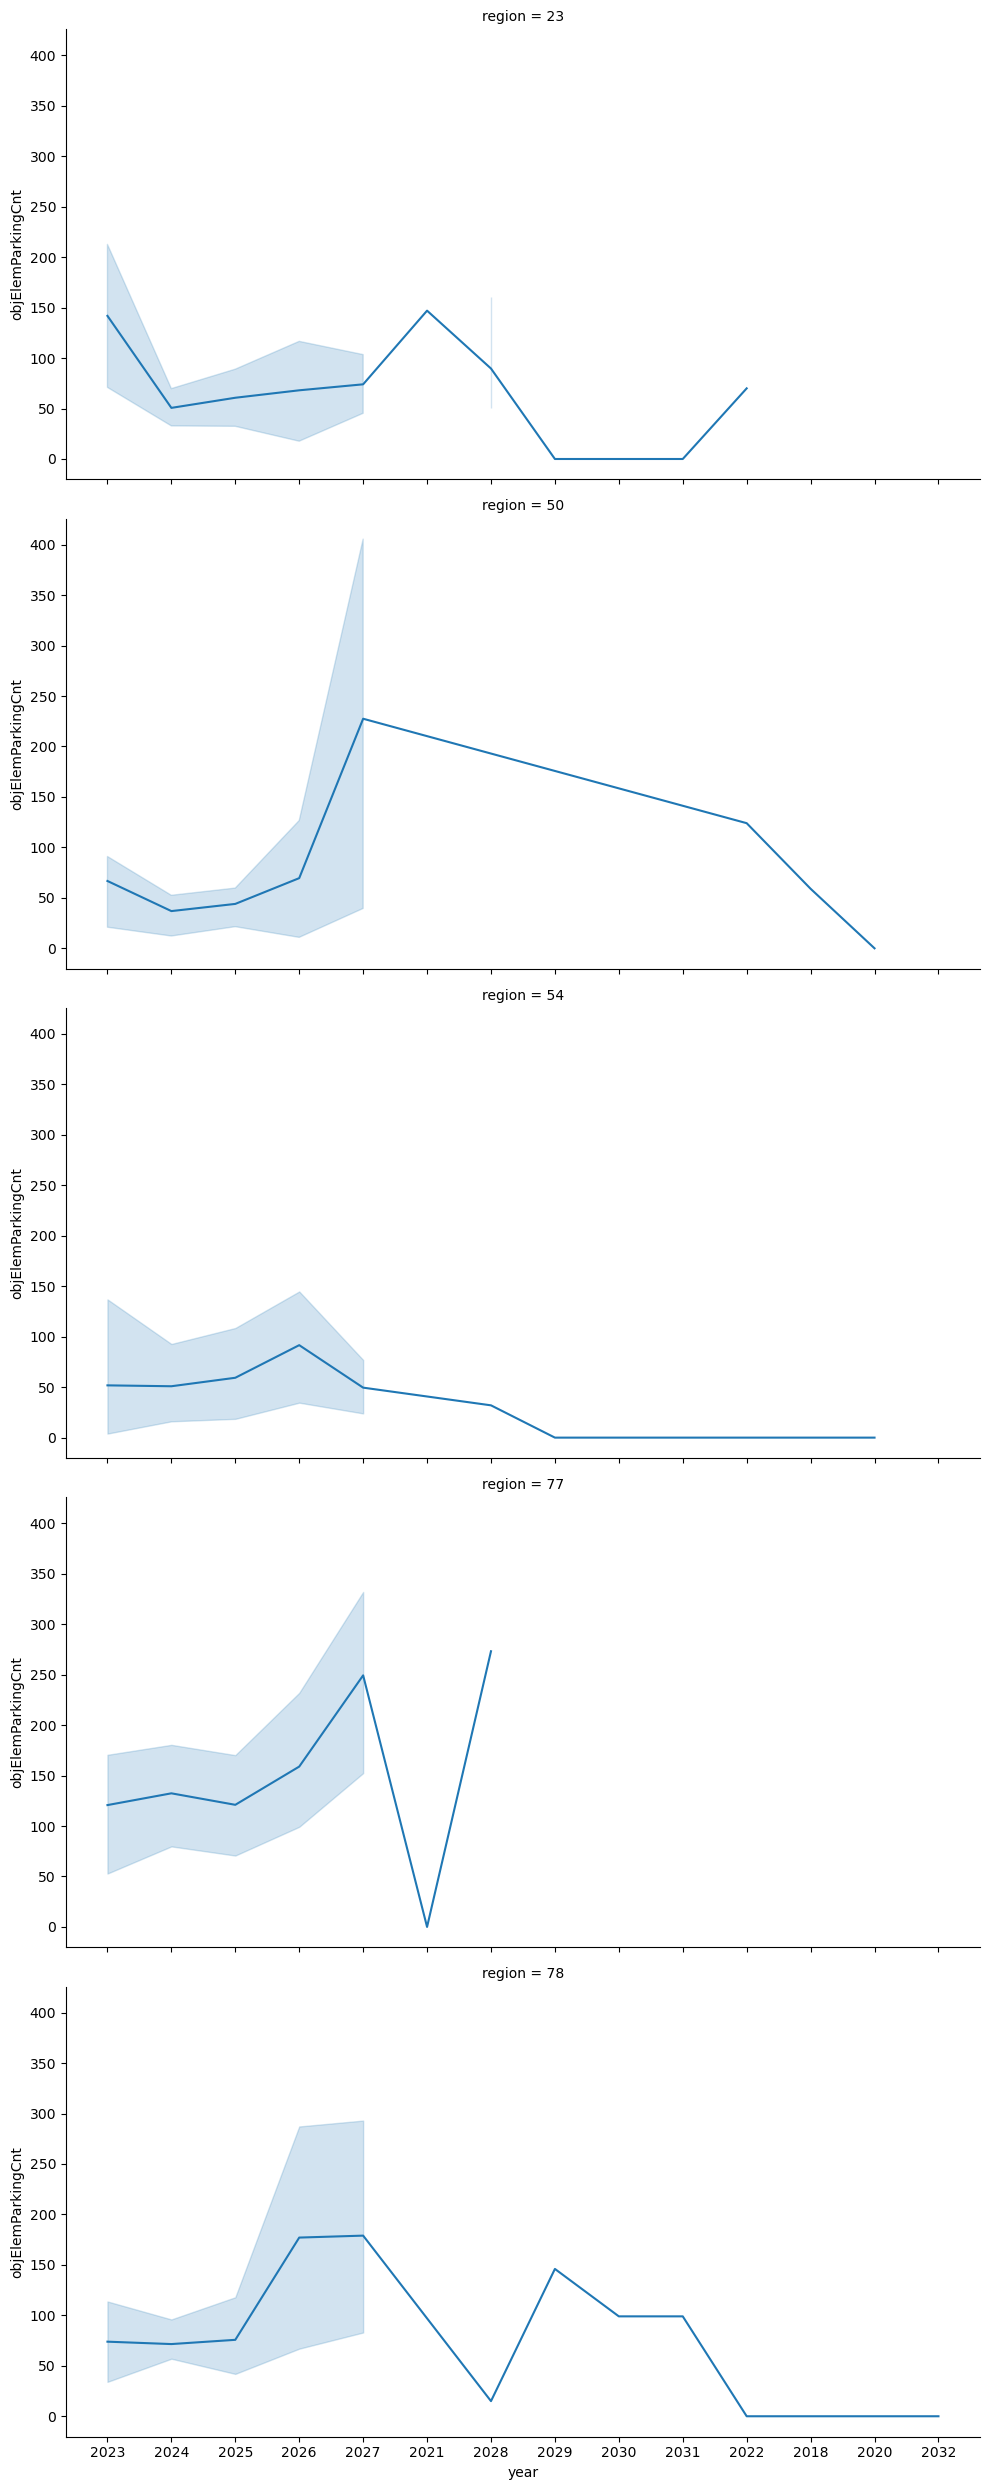

In [729]:
target=['objElemParkingCnt','objFloorCnt','objFlatCnt']

sns.relplot(
    x='year',
    y='objElemParkingCnt',
    # hue='objLkClassDesc',
    data=df.groupby(['region','objLkClassDesc','year'])['objElemParkingCnt'].mean().reset_index(),
    row='region',
    kind='line',
    aspect=2,
    height=5)

График цен

In [651]:
df_prices = df[['region','objLkClassDesc','year','med_price','avg_price']]
df_price_long = pd.melt(df_prices,var_name='type',value_name='price',
                        id_vars=['region','objLkClassDesc','year'])
df_price_long

,region,objLkClassDesc,year,type,price
0,54,Комфорт,2024,med_price,116964
1,50,Комфорт,2023,med_price,95270
2,50,Комфорт,2023,med_price,100727
3,54,Типовой,2024,med_price,77721
4,54,Типовой,2024,med_price,77721
...,...,...,...,...,...
7755,50,Типовой,2024,avg_price,85604
7756,50,Типовой,2025,avg_price,181766
7757,50,Типовой,2024,avg_price,85610
7758,50,Типовой,2024,avg_price,85634


In [684]:
df_price_long.groupby(['region','objLkClassDesc','year','type'])['price'].mean().reset_index()

,region,objLkClassDesc,year,type,price
0,23,Бизнес,2023,avg_price,88812.000000
1,23,Бизнес,2023,med_price,88812.000000
2,23,Бизнес,2024,avg_price,270777.319149
3,23,Бизнес,2024,med_price,261306.127660
4,23,Бизнес,2025,avg_price,354973.250000
...,...,...,...,...,...
229,78,Элитный,2025,med_price,357197.000000
230,78,Элитный,2026,avg_price,373728.333333
231,78,Элитный,2026,med_price,373728.333333
232,78,Элитный,2027,avg_price,372993.000000


d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


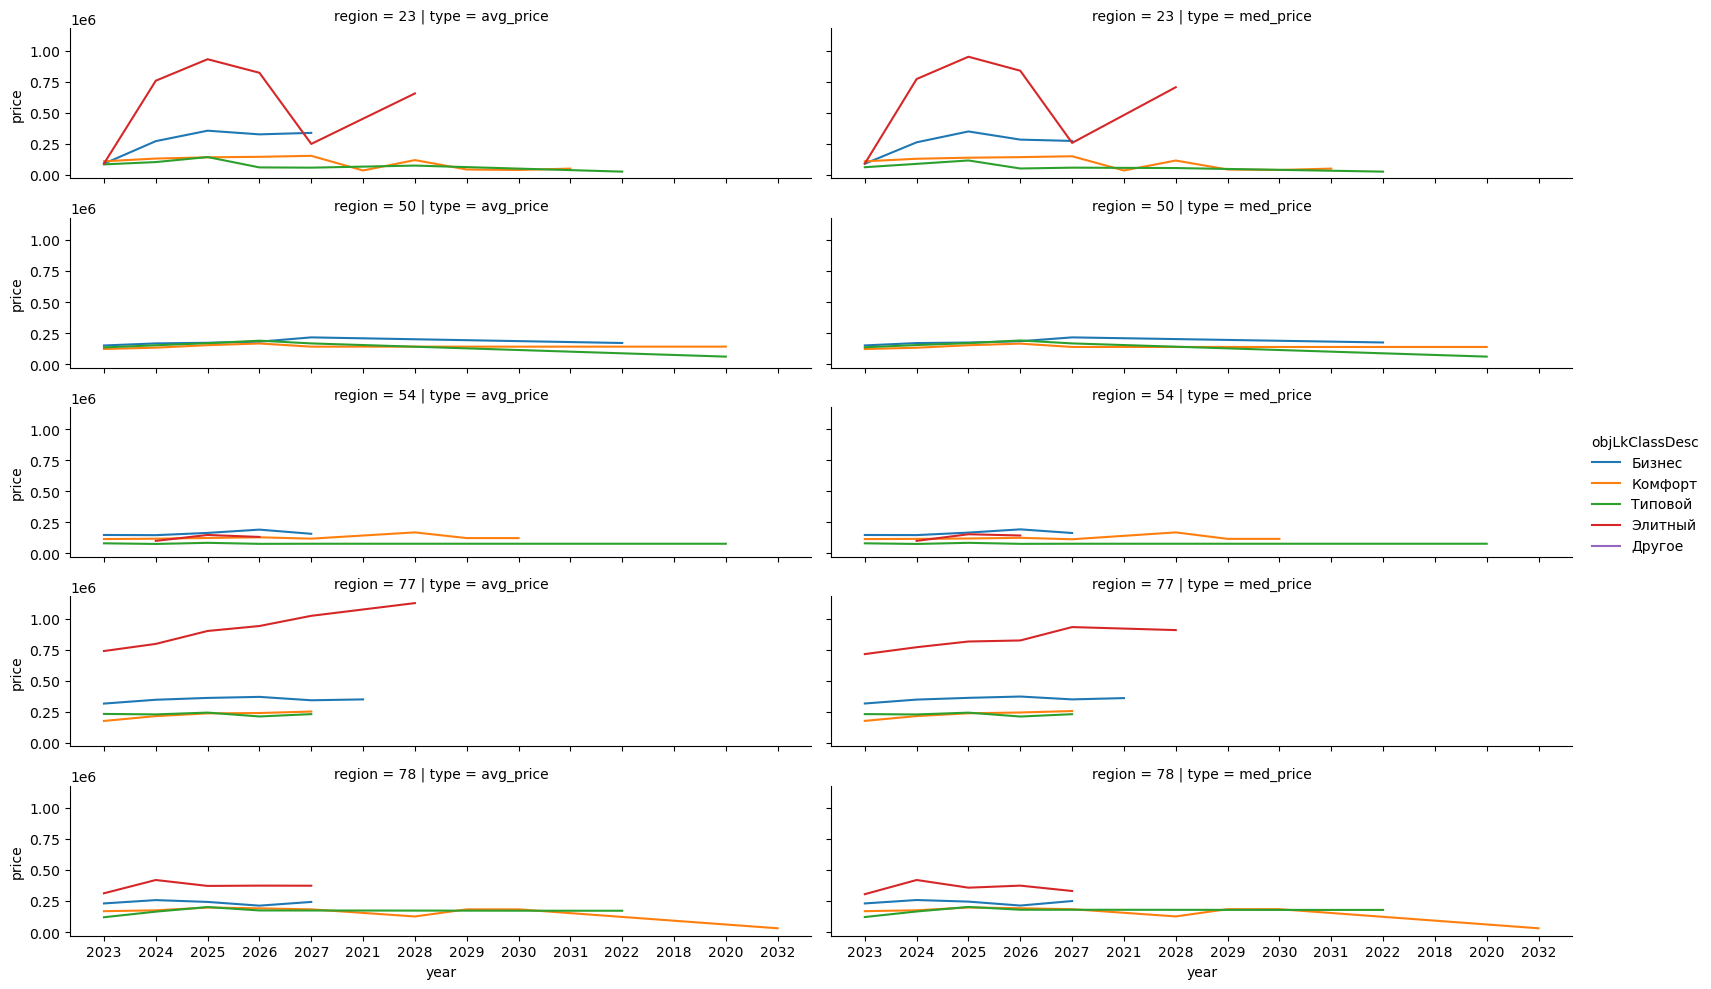

In [701]:
sns.relplot(
    x='year',
    y='price',
    hue='objLkClassDesc',
    data=df_price_long.groupby(['region','objLkClassDesc','year','type'])['price'].mean().reset_index(),
    row='region',
    kind='line',
    col='type',
    aspect=4,
    height=2)



в 23 регионе цены на элитное жилье имеют сильное колебание от года к году, тогда как в других регионах,цены более стабильные. 
в 77 регионе сильнее всего растет элитное жилье

Посмотрим среднее значение цены по регионам за период по нескольим метрикам

In [646]:
df_long = pd.melt(df,var_name='type',value_name='znach',
                  id_vars=['id','region','objLkClassDesc','residentialBuildings','objPriceAvg','objReady100PercDt','year'])


,id,region,objLkClassDesc,residentialBuildings,objPriceAvg,objReady100PercDt,year,type,znach
0,56006,54,Комфорт,1,NaN,2024-12-31,2024,objElemLivingCnt,24
1,18709,50,Комфорт,1,95270.0,2023-12-31,2023,objElemLivingCnt,272
2,18708,50,Комфорт,1,100727.0,2023-12-31,2023,objElemLivingCnt,272
3,27803,54,Типовой,1,NaN,2024-03-31,2024,objElemLivingCnt,12
4,23862,54,Типовой,1,NaN,2024-03-31,2024,objElemLivingCnt,6
...,...,...,...,...,...,...,...,...,...
31035,28071,50,Типовой,1,85604.0,2024-06-30,2024,avg_price,85604
31036,28070,50,Типовой,1,181766.0,2025-03-31,2025,avg_price,181766
31037,28072,50,Типовой,1,85610.0,2024-06-30,2024,avg_price,85610
31038,28073,50,Типовой,1,85634.0,2024-06-30,2024,avg_price,85634


In [644]:
df

,id,region,objElemLivingCnt,objElemParkingCnt,objSquareLiving,objLkClassDesc,residentialBuildings,objFloorCnt,objFlatCnt,objFlatSq,objPriceAvg,objReady100PercDt,year,med_price,avg_price
0,56006,54,24,0,1003.20,Комфорт,1,4,24,1003.2,NaN,2024-12-31,2024,116964,123119
1,18709,50,272,30,12093.84,Комфорт,1,18,272,12093.84,95270.0,2023-12-31,2023,95270,95270
2,18708,50,272,0,12057.80,Комфорт,1,17,272,12057.8,100727.0,2023-12-31,2023,100727,100727
3,27803,54,12,0,889.20,Типовой,1,3,12,889.2,NaN,2024-03-31,2024,77721,77696
4,23862,54,6,0,787.20,Типовой,1,3,6,787.2,NaN,2024-03-31,2024,77721,77696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,28071,50,288,0,14870.40,Типовой,1,26,288,14870.4,85604.0,2024-06-30,2024,85604,85604
3876,28070,50,768,0,29620.10,Типовой,1,26,768,29620.1,181766.0,2025-03-31,2025,181766,181766
3877,28072,50,312,0,14788.80,Типовой,1,26,312,14788.8,85610.0,2024-06-30,2024,85610,85610
3878,28073,50,312,0,14872.80,Типовой,1,26,312,14872.8,85634.0,2024-06-30,2024,85634,85634


d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


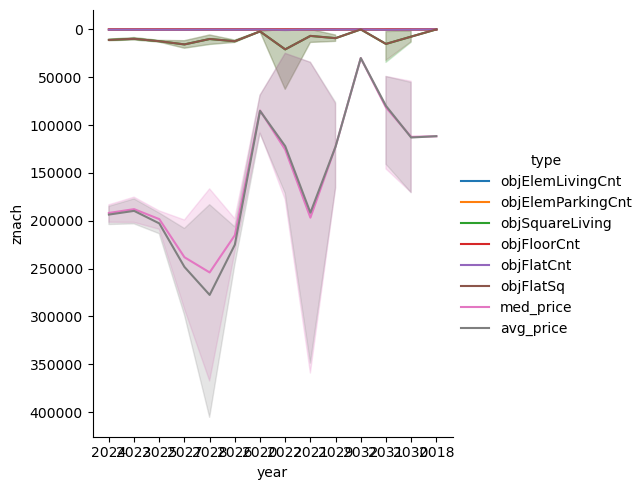

In [650]:
sns.relplot(
    x='year',
    y='znach',
    hue='type',
    data=df_long,
    kind='line')

In [573]:
top_reg=df.groupby(['region']).count().sort_values('id',ascending=False).reset_index().head(5)['region']
test=df.copy()
test=df[df['region'].isin(top_reg)].reset_index(drop=True)

In [422]:
test.groupby(['region','objLkClassDesc','residentialBuildings','date'])['objElemLivingCnt'].mean().reset_index()

,region,objLkClassDesc,residentialBuildings,date,objElemLivingCnt
0,23,Бизнес,0,2024-03-31,0.0
1,23,Бизнес,0,2024-06-30,0.0
2,23,Бизнес,0,2024-09-30,0.0
3,23,Бизнес,0,2024-12-31,0.0
4,23,Бизнес,0,2025-03-31,0.0
...,...,...,...,...,...
455,78,Элитный,1,2024-12-31,200.5
456,78,Элитный,1,2025-06-30,68.0
457,78,Элитный,1,2025-12-31,88.0
458,78,Элитный,1,2026-09-30,717.0


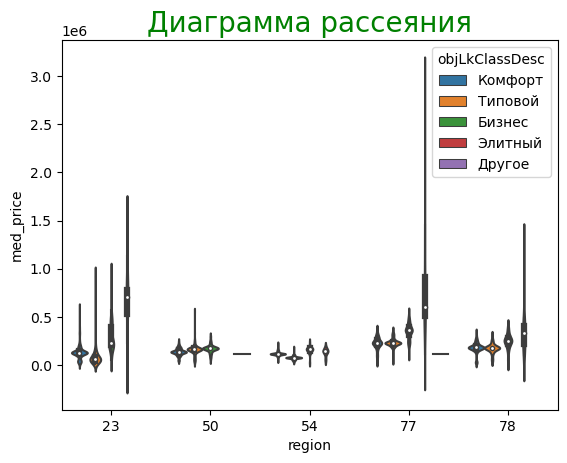

In [473]:
sns.violinplot(
    x='region',
    y='med_price',
    data=test,
    hue='objLkClassDesc'
    # kind='scatter'
#     kind='line'
)
plt.title('Диаграмма рассеяния', size=20, color='g');

In [498]:
d=test.groupby(['region','year'])['avg_price'].mean().reset_index()


<Axes: xlabel='year'>

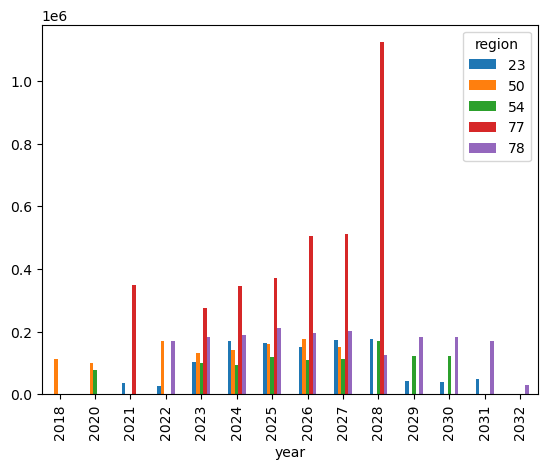

In [500]:
d.pivot(index='year',columns='region',values='avg_price').plot(kind='bar')

In [494]:
test['year'] = test['date'].dt.year

In [501]:
d.pivot(index='year',columns='region',values='avg_price')

region,23,50,54,77,78
year,,,,,
2018,NaN,111650.000000,NaN,NaN,NaN
2020,NaN,100125.500000,77696.000000,NaN,NaN
2021,34367.000000,NaN,NaN,3.488980e+05,NaN
2022,25072.000000,169746.000000,NaN,NaN,171373.000000
2023,103281.293333,131338.466667,99184.468750,2.765664e+05,182476.313433
2024,170891.332203,142812.778107,94154.928030,3.470315e+05,190397.920561
2025,164232.777202,160417.731707,120022.125000,3.709463e+05,210015.475138
2026,151792.995968,175971.869565,109068.627907,5.057283e+05,196848.213333
2027,174118.062500,150346.750000,113270.250000,5.106836e+05,201770.769231


In [379]:
test.groupby(['date','region','objLkClassDesc'])['med_price'].mean()

date        region  objLkClassDesc
2018-12-31  50      Другое            111736.0
2020-03-31  54      Типовой            77721.0
2020-09-30  50      Комфорт           137783.0
2020-12-31  50      Типовой            59988.0
2021-09-30  23      Комфорт            34367.0
                                        ...   
2031-06-30  23      Комфорт            49033.0
2031-09-30  23      Комфорт            49649.0
2031-12-31  23      Комфорт            49728.0
            78      Типовой           177900.0
2032-12-31  78      Комфорт            30000.0
Name: med_price, Length: 308, dtype: float64

In [390]:
df

,Категория,Значение
0,А,1
1,А,2
2,Б,3
3,Б,4
4,В,5
5,В,6


In [389]:
df = pd.DataFrame({
    'Категория': ['А', 'А', 'Б', 'Б', 'В', 'В'],
    'Значение': [1, 2, 3, 4, 5, 6]
})

# Используем метод pivot
result = df.pivot(index='Категория', columns='Значение', values='Значение')

print(result)

Значение     1    2    3    4    5    6
Категория                              
А          1.0  2.0  NaN  NaN  NaN  NaN
Б          NaN  NaN  3.0  4.0  NaN  NaN
В          NaN  NaN  NaN  NaN  5.0  6.0


d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


KeyboardInterrupt: 

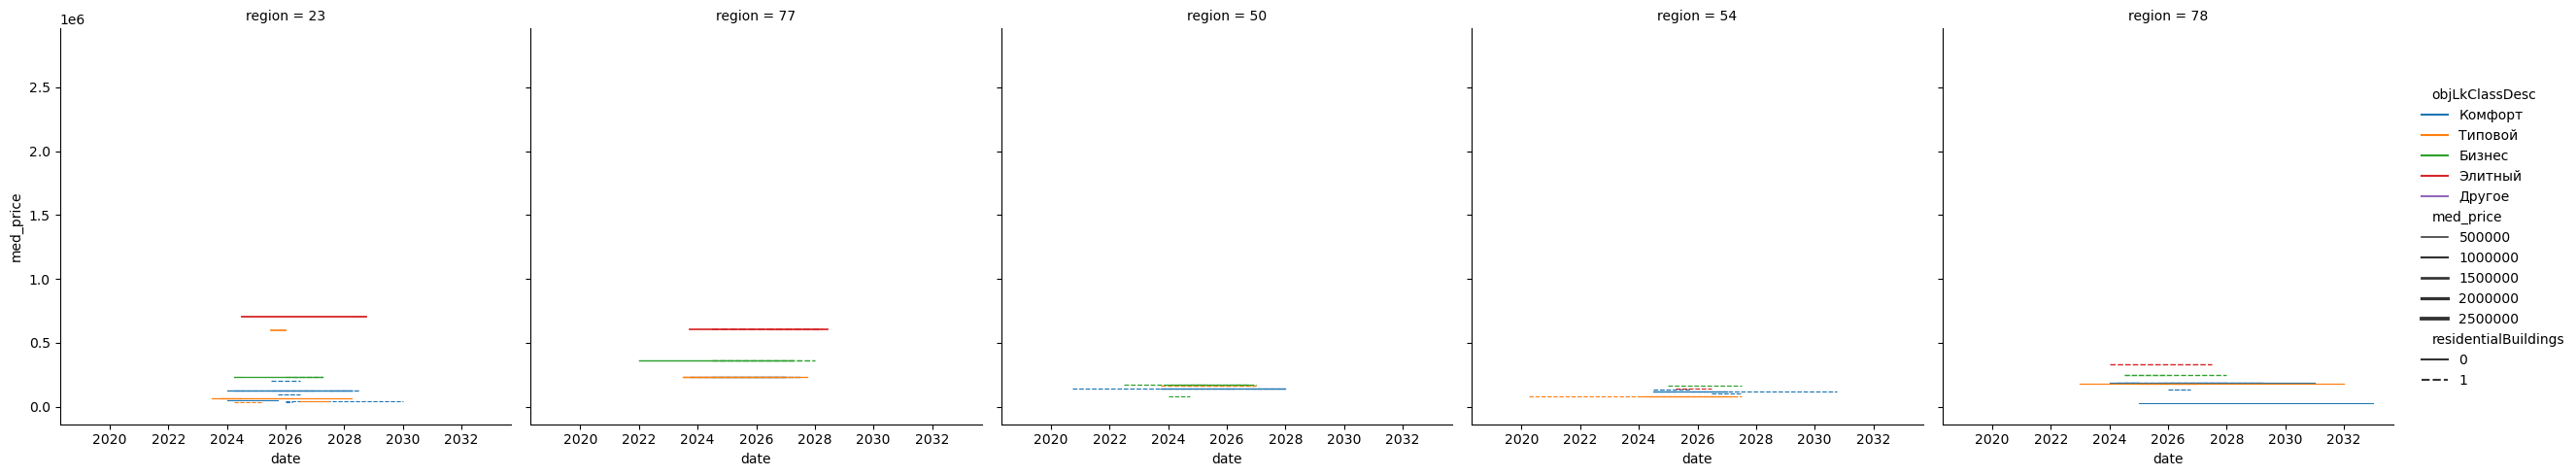

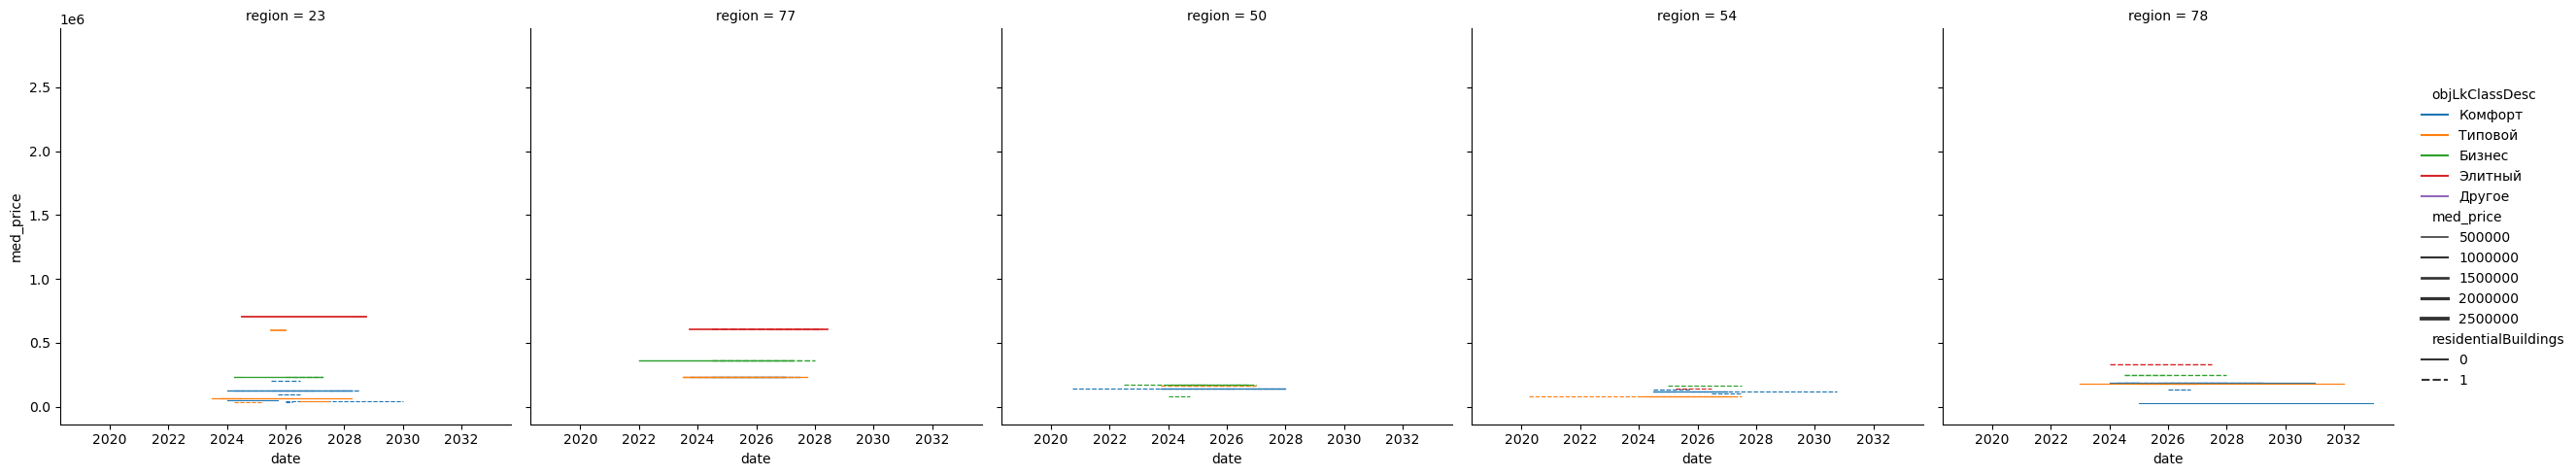

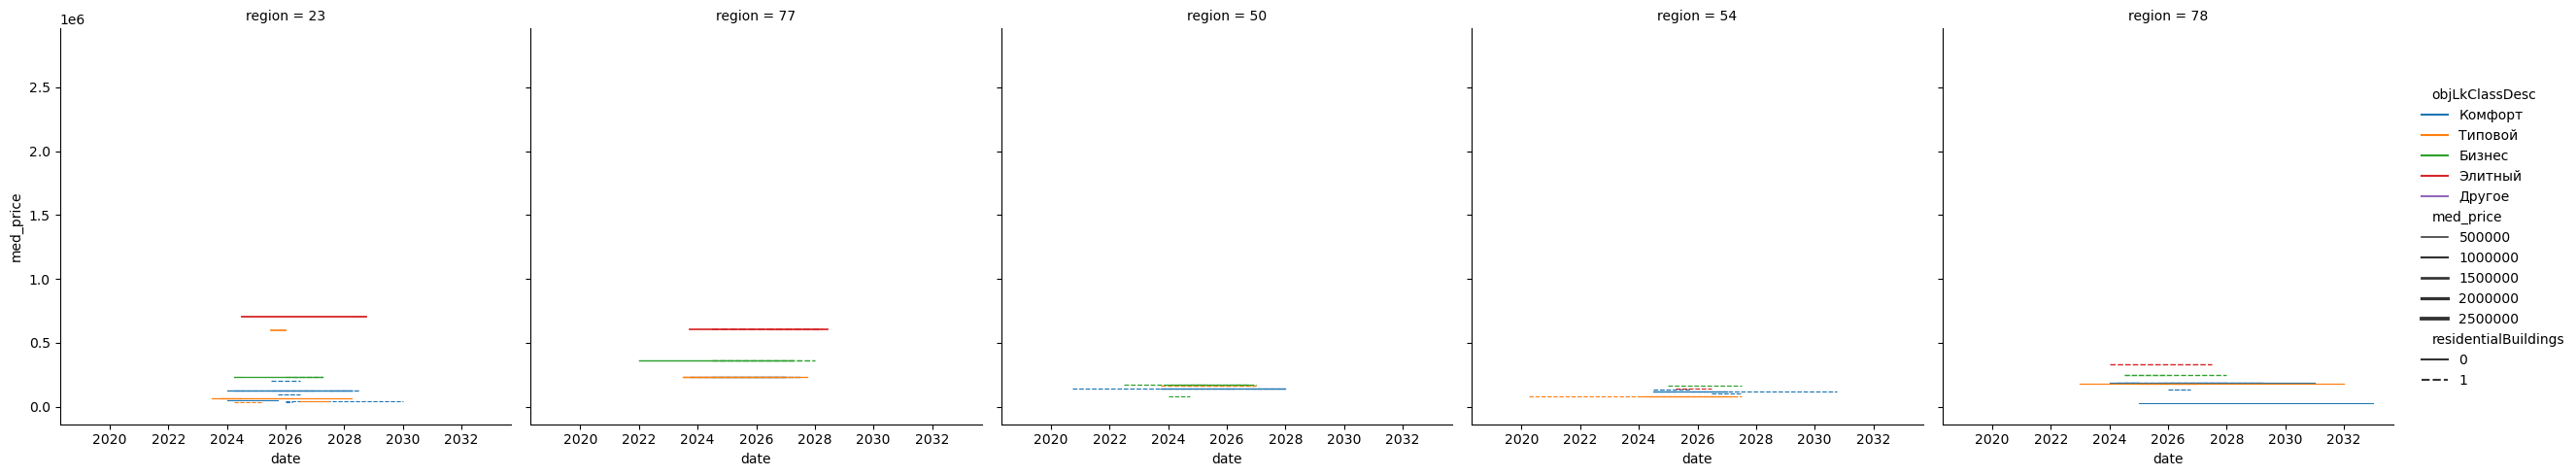

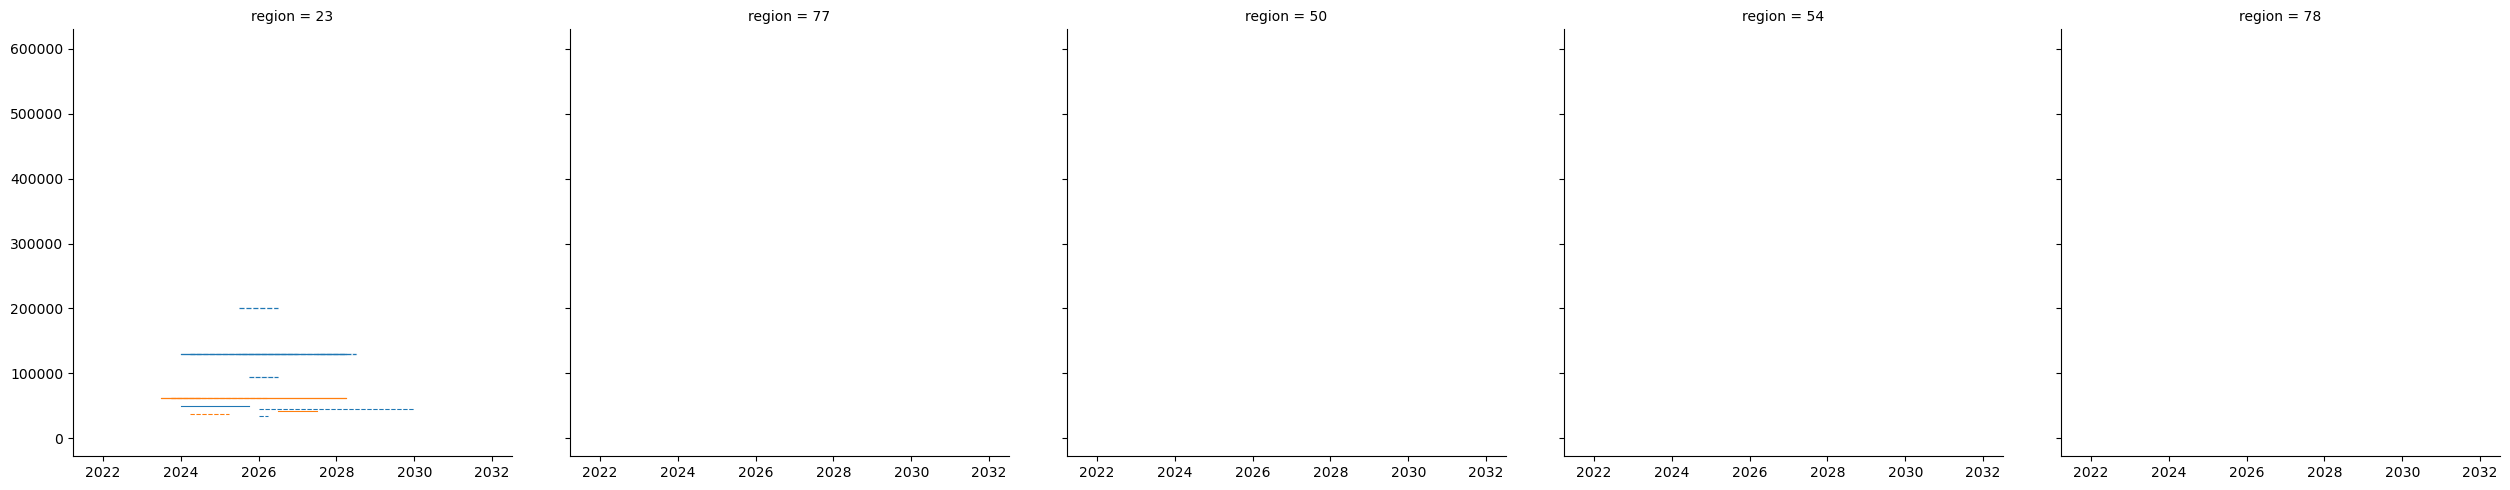

In [347]:
graph_titles = ['График 1', 'График 2', 'График 3', 'График 4']

for i, title in enumerate(graph_titles):
    sns.relplot(
        x='date',
        y='med_price',
        data=test,
        hue='objLkClassDesc',
        col='region',
        col_wrap=5,
        col_order=top_reg,
        style='residentialBuildings',
        size='med_price',
        kind='line',
        label=title
    )

plt.title('Сравнение цен по региону и классу жилья по годам', size=20, color='g')

# Функция для форматирования оси y
def format_tick(value, pos):
    return f'{value}'

# Форматирование оси y с помощью функции matplotlib.ticker.FuncFormatter
formatter = mtick.FuncFormatter(format_tick)
plt.gca().yaxis.set_major_formatter(formatter)

# Добавьте сетку для основной оси y
plt.gca().yaxis.grid(True)

# Добавьте сетку для основной оси x
plt.gca().xaxis.grid(True)

# Добавьте второстепенную ось y и сетку
plt.gca().twinx()

# Установите межинтервальные значения для основных осей y и x
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=5))
plt.gca().xaxis.set_major_locator(mtick.MaxNLocator(nbins=5))

# Установите межинтервальные значения для второстепенной оси y
plt.gca().secondary_yaxis().set_major_locator(mtick.MaxNLocator(nbins=5))

plt.show()